In [97]:
import pandas as pd
import numpy as np
import scipy
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0)

## Data understanding

In [74]:
df = pd.read_csv('./regression_data/regression_train.csv')

In [75]:
df.head()

,target,X1,X2,X3,X4,X5,X6,X7
0,NaN,-0.546168,NaN,47.063305,1.611370,-65.882137,0,-16.672865
1,47.735389,3.074317,-2.836000,49.396649,0.261998,-66.570716,0,-6.664599
2,NaN,-1.485531,-13.102537,42.367991,3.991558,-67.108014,8,-30.790962
3,908.202209,6.907396,-0.308967,57.228787,0.256771,-66.181266,5,-0.726072
4,1640.461863,1.916788,3.460290,51.703375,2.463790,-65.143663,5,8.131680


In [44]:
f'dataset columns: {df.columns.values}'

"dataset columns: ['target' 'X1' 'X2' 'X3' 'X4' 'X5' 'X6' 'X7']"

In [45]:
f'Rows size: {df.shape[0]}, Columns size: {df.shape[1]}'

'Rows size: 1042, Columns size: 8'

In [46]:
target = 'target'
input_cols_continous = ['X1', 'X2', 'X3', 'X4', 'X5',  'X7']
input_cols_discrete = ['X6']

In [47]:
df_desc = df[input_cols+[target]].describe().T
df_desc['has_missing_value'] = pd.isnull(df[input_cols+[target]]).any()

In [194]:
print("Geral statistics of the data")
df_desc

Geral statistics of the data


,count,mean,std,min,25%,50%,75%,max,has_missing_value
X1,1042.0,2.421925,3.182976,-8.699406,0.170590,2.508671,4.540218,12.380693,False
X2,1031.0,-0.460781,4.426286,-13.651540,-3.307931,-0.461150,2.406651,12.926106,True
X3,1042.0,52.094329,31.374828,38.035456,47.087106,49.972867,52.674305,500.000000,False
X4,1042.0,2.462871,2.541632,0.002360,0.671196,1.652609,3.361181,18.813009,False
X5,1042.0,-65.284233,9.033489,-121.450423,-69.126630,-65.360660,-61.187635,53.919202,False
X6,1042.0,4.381958,3.290306,0.000000,0.000000,5.000000,8.000000,8.000000,False
X7,1042.0,-1.287435,11.066380,-69.835905,-7.830007,-1.074191,5.659476,30.376348,False
target,715.0,1349.940229,1593.201095,0.062551,230.632308,808.374368,1849.754221,10382.469480,True


In [49]:
print("Column Types:")
df.dtypes

Column Types:


target    float64
X1        float64
X2        float64
X3        float64
X4        float64
X5        float64
X6          int64
X7        float64
dtype: object

COLUMN X6 DISTRIBUTION


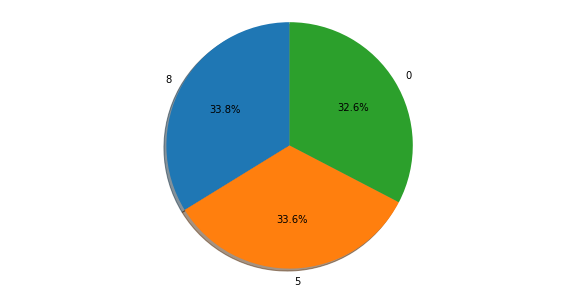

In [50]:
print("COLUMN X6 DISTRIBUTION")
count_categorical= df['X6'].value_counts(dropna=False)
labels = list(count_categorical.index)
sizes = list(count_categorical.values)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

In [51]:
for c in ['X2', target]:
    print(f"Porcentage. of missing values {df[pd.isna(df[c])].shape[0]/df.shape[0] * 100} on COLUMN {c}")

Porcentage. of missing values 1.055662188099808 on COLUMN X2
Porcentage. of missing values 31.381957773512475 on COLUMN target


In [52]:
df = df[pd.notna(df['X2'])]
df = df[pd.notna(df[target])]

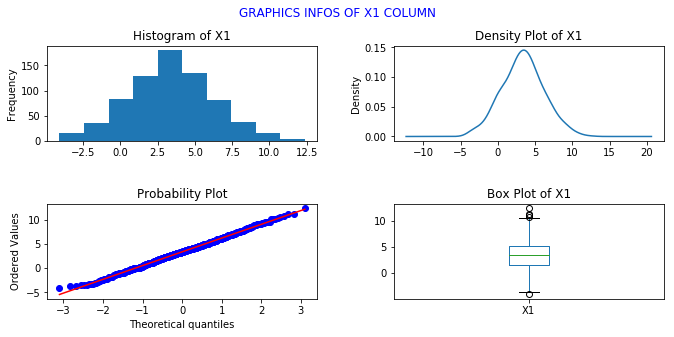

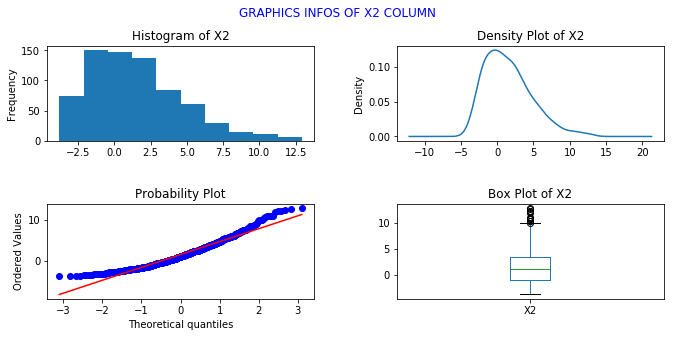

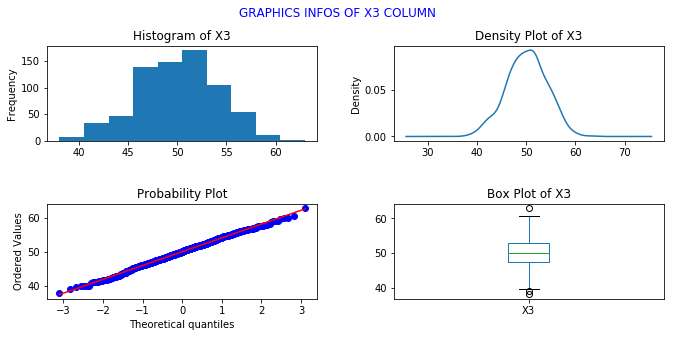

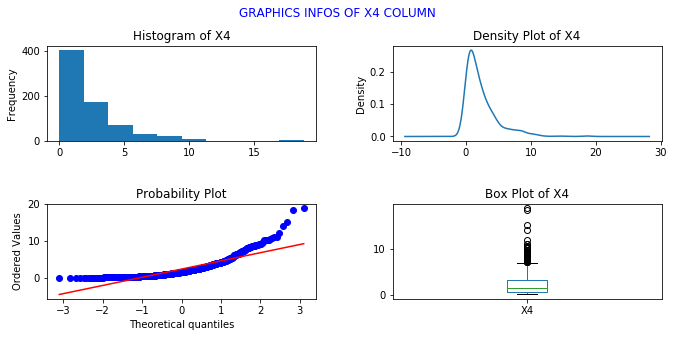

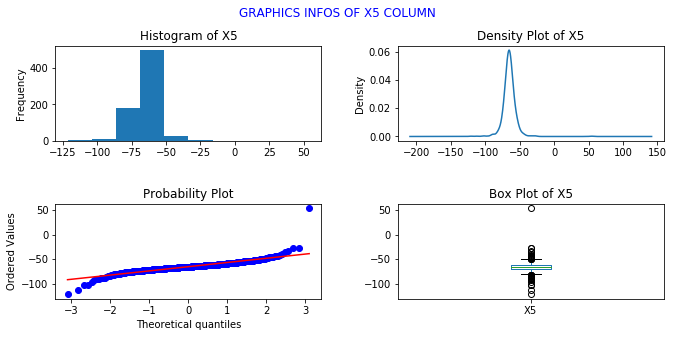

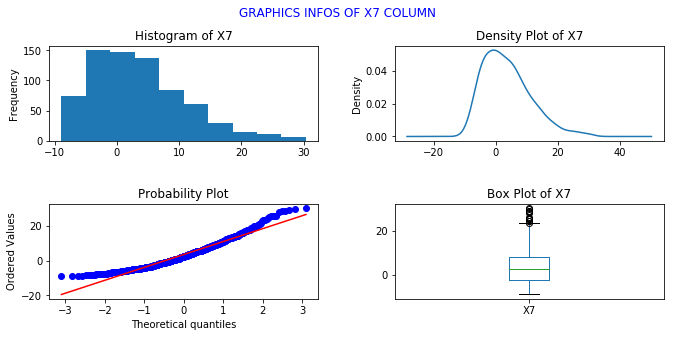

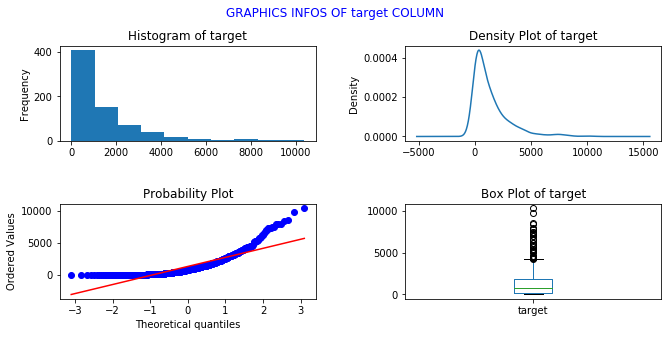

In [53]:
import scipy.stats as stats
    
def custom_barplot(df, col1=''):
    # based on https://github.com/Azure/Azure-TDSP-Utilities/blob/master/DataScienceUtilities/DataReport-Utils/Python/IDEAR-Python-AzureNotebooks.ipynb
    fig, axes = plt.subplots(2,2)
    axes = axes.reshape(-1)
    df[col1].plot(ax=axes[0], kind='hist')
    axes[0].set_title('Histogram of {}'.format(col1))
    df[col1].plot(ax=axes[1], kind='kde')
    axes[1].set_title('Density Plot of {}'.format(col1))
    ax3 = plt.subplot(223)
    stats.probplot(df[col1], plot=plt)
    axes[2].set_title('QQ Plot of {}'.format(col1))
    df[col1].plot(ax=axes[3], kind='box')
    axes[3].set_title('Box Plot of {}'.format(col1))
    fig.suptitle(f'GRAPHICS INFOS OF {col1} COLUMN', color='blue', fontsize=12)

    fig.tight_layout(pad=3.0)
for c in input_cols_continous+[target]:
    custom_barplot(df, c)      

In [38]:
def numerical_relations(df, col1, col2):
    x = df[col2]
    y = df[col1]
   
    return round(scipy.stats.pearsonr(x, y)[0], 6)

all_pearson = pd.DataFrame()
for c in input_cols+[target]:
    cols = []
    for c1 in input_cols+[target]:
        cols.append(numerical_relations(df, c, c1))
    all_pearson[c] = cols
    
all_pearson['input_col'] = input_cols+[target]
all_pearson.set_index('input_col', inplace=True)
all_pearson

,X1,X2,X3,X4,X5,X6,X7,target
input_col,,,,,,,,
X1,1.000000,0.391877,-0.043520,0.004531,0.009388,0.034558,0.391877,0.514485
X2,0.391877,1.000000,0.030203,0.091770,-0.055510,0.045088,1.000000,0.938318
X3,-0.043520,0.030203,1.000000,0.095165,0.010467,-0.004720,0.030203,0.057441
X4,0.004531,0.091770,0.095165,1.000000,-0.057918,-0.021941,0.091770,-0.011001
X5,0.009388,-0.055510,0.010467,-0.057918,1.000000,-0.050802,-0.055510,-0.023407
X6,0.034558,0.045088,-0.004720,-0.021941,-0.050802,1.000000,0.045088,0.040508
X7,0.391877,1.000000,0.030203,0.091770,-0.055510,0.045088,1.000000,0.938318
target,0.514485,0.938318,0.057441,-0.011001,-0.023407,0.040508,0.938318,1.000000


### Interpretations of the data: 
- There are missing values on the target and X2;
- X1, X2, and X7 are the most correlated variables in relation to the target; 
- X2 and X7 has the same distribution, in this way I can just don't consider X2 column;
- X7 is the columns that have the highest linear correlation  with the target;
- There are missing values on the Target, in this way, I create two suppositions about that: 1- the data was just lost, and I can not handle that, or 2- this is an inherent behavior of the problems. I will use the supposition 2 because there approximately 30 % of the data is with missing values in the target. Therefore I will substitute the missing values on target to 0
- Interpretation of Graphics Infos:

    - target: most of the values are in the range 0 to 1000, and its minimum is 0.06 and maximum is 10382.4
    - 'X1': has approximately a normal distribution, and its minimum is -8.6 and maximum is 12.3
    - 'X2': the most of the values are in the range -2.5 to 2.5, its minimum is -13.6 and the maximum is 12.9
    - 'X3': as approximately a normal distribution and its minimum is 38.0 and maximum is 500
    - 'X4': the most of the values are in the range 0 to 4, its minimum is 0.002 and the maximum is 18.8
    - 'X5': the most of the values are on the range -75 to -50, this column has the most scattered data, its minimum is 121.4 and the maximum is 53.9
    - 'X6': is the categorical value of 3 types, its categories are balanced
    - 'X7': the most of the values are in the range -69.8 to 30.3, being well distributed, its minimum is -69.8 and the maximum is 30.3

## MODELING

### preprocessing 

In [113]:
target = 'target'
input_cols_continous = ['X1', 'X3', 'X4', 'X5',  'X7']
input_cols_discrete = ['X6']
to_exclude = ["X2"]

df = pd.read_csv('./regression_data/regression_train.csv').drop(columns=to_exclude)
df_test = pd.read_csv('./regression_data/regression_test.csv').drop(columns=to_exclude)

df[target] = df[target].apply(lambda x: x if pd.notna(x) else 0)
df_test[target] = df_test[target].apply(lambda x: x if pd.notna(x) else 0)

scaler_cont = MinMaxScaler()
scaler_target = MinMaxScaler()
scaler_cat = OneHotEncoder(categories='auto', sparse=False)
scaler_target.fit(df[target].values.reshape(-1, 1))
scaler_cont.fit(df[input_cols_continous])
scaler_cat.fit(df[input_cols_discrete])

x_train_cont = scaler_cont.transform(df[input_cols_continous])
x_train_cat = scaler_cat.transform(df[input_cols_discrete])
y_train =  scaler_target.transform(df[target].values.reshape(-1, 1)).flatten()

x_test_cont = scaler_cont.transform(df_test[input_cols_continous])
x_test_cat = scaler_cat.transform(df_test[input_cols_discrete])
y_test =  scaler_target.transform(df_test[target].values.reshape(-1, 1)).flatten()

x_train = [ list(c) + list(h) for c,h in zip(x_train_cont, x_train_cat)]

x_test = [ list(c) + list(h) for c,h in zip(x_test_cont, x_test_cat)]

#### Training

In [134]:
models = {}
parameters = {'max_depth':[5, 8, 15, 30], 'min_samples_leaf':[2, 5,10], 'n_estimators': [50, 100, 150]}
model = RandomForestRegressor(n_jobs = -1)
rf_model = GridSearchCV(model, parameters, n_jobs = -1, cv=3)
rf_model.fit(x_train, y_train)
importance_features = rf_model.best_estimator_.feature_importances_
models['rf'] = rf_model
parameters = {'C':[0.01, 0.1, 10, 100, 1000], 'gamma':[0.1, 0.001, 0.0001]}
model = SVR(kernel='rbf')
svm_model = GridSearchCV(model, parameters, n_jobs = -1, cv=3)
svm_model.fit(x_train, y_train)
models['svm'] = svm_model

In [125]:
from sklearn.metrics import r2_score

def mean_square_error(y_true, y_pred):
    y_true = np.asmatrix(y_true).reshape(-1)
    y_pred = np.asmatrix(y_pred).reshape(-1)

    return np.square(np.subtract(y_true, y_pred)).mean()

def root_mean_square_error(y_true, y_pred):

    return mean_square_error(y_true, y_pred)**0.5

metrics = {}
for name, model in models.items():
    model.predict(x_test)
    prev = model.predict(x_test)
    rmse = root_mean_square_error(y_true=y_test, y_pred= prev)
    r2 = r2_score(y_true=y_test, y_pred= prev)
    cor = round(scipy.stats.pearsonr(y_test, prev)[0], 6)
    metrics[name] = {'r2_score':r2, 'RMSE':rmse, 'cor':cor}

In [126]:
pd.DataFrame(metrics)

,rf,svm
r2_score,0.911976,0.751045
RMSE,0.033223,0.055872
cor,0.955036,0.900790


The Random forest found the best results in all metrics (test set)

### IMPORTANCE FEATURES

In [180]:
all_feats = input_cols_continous+list(scaler_cat.categories_[0])

In [188]:
x = [ {'column':all_feats[l], 'score':importance_features[l]} for l in np.argsort(importance_features)]
df_importance = pd.DataFrame(x)

In [193]:
df_importance.sort_values('score', ascending=False)

,column,score
7,X7,0.944642
6,X1,0.023020
5,X3,0.012757
4,X4,0.011509
3,0,0.004569
2,X5,0.002640
1,8,0.000708
0,5,0.000155


The process of the random forest computed the column X7 as the most important feature, this result corroborates with the previous analysis of the correlation